In [62]:
# Useful starting lines
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Load the data

In [63]:
import datetime
from helpers import *

height, weight, gender = load_data(sub_sample=False, add_outlier=False)
x, mean_x, std_x = standardize(height)
y, tx = build_model_data(x, weight)

In [64]:
y.shape, tx.shape

((10000,), (10000, 2))

### NB: throughout this laboratory the data has the following format: 
  * there are **N = 10000** data entries
  * **y** represents the column vector containing weight information -- that which we wish to predict/the output (see also the first page of $\texttt{exercise02.pdf}$). Its **shape** is **(N,)**.
  * **tx** represents the matrix $\tilde{X}$ formed by laterally concatenating a column vector of 1s to the column vector of height information -- the input data (see also the first page of $\texttt{exercise02.pdf}$). Its **shape** is **(N,2)**.

# 1. Computing the Cost Function
Fill in the `compute_loss` function below:

In [65]:
def compute_loss(y, tx, w, loss_type = "MSE"):
    """Calculate the loss using either MSE or MAE.

    Args:
        y: numpy array of shape=(N, )
        tx: numpy array of shape=(N,2)
        w: numpy array of shape=(2,). The vector of model parameters.

    Returns:
        the value of the loss (a scalar), corresponding to the input parameters w.
    """
    e = y - tx @ w
    N = len(y)
        
    MAE = 1/N * sum(np.abs(e[i]) for i in range(N))
    MSE = 1/(2*N) * (e @ e)
    MSE2 = 1/(2*N) * sum(e[i]**2 for i in range(N)) # equivalent
    
    if loss_type == 'MSE' : 
        return MSE
    else : 
        return MAE
    raise ValueError("Loss type should be MSE or MAE")

In [66]:
# TEST on small dataset : N=2
y  = np.array([1, 2])
tx = np.array([[1, 1],   # first row: [1, x1] = [1, 1]
               [1, 2]])  # second row: [1, x2] = [1, 2]
w  = np.array([0, 1])    # w0=0, w1=1

print("MSE:", compute_loss(y, tx, w, "MSE"))   # expect 0
print("MAE:", compute_loss(y, tx, w, "MAE"))   # expect 0

# change weights a bit
w = np.array([0, 0])  # predict constant 0 ; e = [1,2] - [0,0] = [1,2]

print("MSE:", compute_loss(y, tx, w, "MSE"))   # (1^2+2^2)/(2*2)=5/4=1.25
print("MAE:", compute_loss(y, tx, w, "MAE"))   # (|1|+|2|)/2=1.5

MSE: 0.0
MAE: 0.0
MSE: 1.25
MAE: 1.5


# 2. Grid Search

Fill in the function `grid_search()` below:

In [67]:
# from costs import *

def grid_search(y, tx, grid_w0, grid_w1):
    """Algorithm for grid search.

    Args:
        y: numpy array of shape=(N, )
        tx: numpy array of shape=(N,2)
        grid_w0: numpy array of shape=(num_grid_pts_w0, ). A 1D array containing num_grid_pts_w0 values of parameter w0 to be tested in the grid search.
        grid_w1: numpy array of shape=(num_grid_pts_w1, ). A 1D array containing num_grid_pts_w1 values of parameter w1 to be tested in the grid search.

    Returns:
        losses: numpy array of shape=(num_grid_pts_w0, num_grid_pts_w1). A 2D array containing the loss value for each combination of w0 and w1
    """
    # ***************************************************
    # INSERT YOUR CODE HERE
    # TODO: compute loss for each combination of w0 and w1.
    # ***************************************************

    losses = np.zeros((len(grid_w0), len(grid_w1)))

    n = len(grid_w0)
    m = len(grid_w1)

    for i, w0 in enumerate(grid_w0) : 
        for j, w1 in enumerate(grid_w1) : 
            w = np.array([grid_w0[i], grid_w1[j]])
            # w = np.array([w0,w1])
            losses[i,j] = compute_loss(y, tx, w)
    return losses

Let us play with the grid search demo now!

Grid Search: loss*=62.36111111111123, w0*=33.33333333333334, w1*=-16.666666666666657, execution time=0.001 seconds


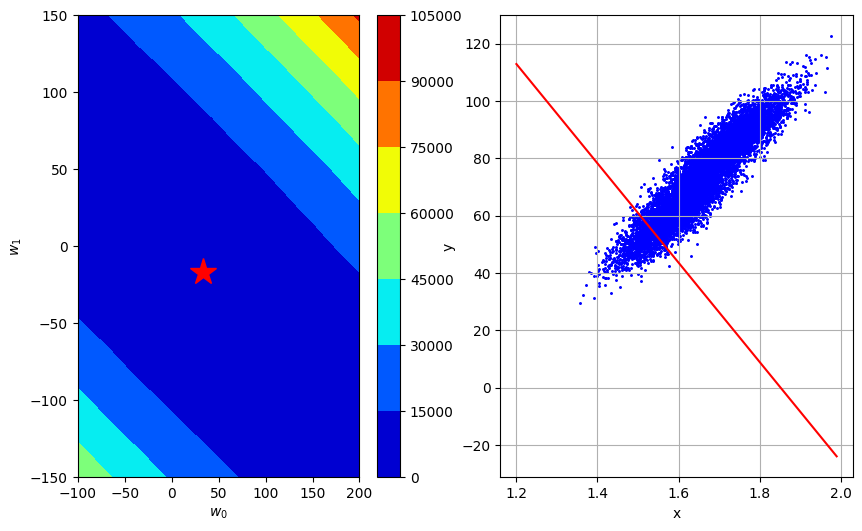

In [68]:
from grid_search import generate_w, get_best_parameters
from plots import grid_visualization

# Generate the grid of parameters to be swept
grid_w0, grid_w1 = generate_w(num_intervals=10)

# Start the grid search
start_time = datetime.datetime.now()
grid_losses = grid_search(y, tx, grid_w0, grid_w1)

# Select the best combinaison
loss_star, w0_star, w1_star = get_best_parameters(grid_w0, grid_w1, grid_losses)
end_time = datetime.datetime.now()
execution_time = (end_time - start_time).total_seconds()

# Print the results
print(
    "Grid Search: loss*={l}, w0*={w0}, w1*={w1}, execution time={t:.3f} seconds".format(
        l=loss_star, w0=w0_star, w1=w1_star, t=execution_time
    )
)

# Plot the results
fig = grid_visualization(grid_losses, grid_w0, grid_w1, mean_x, std_x, height, weight)
fig.set_size_inches(10.0, 6.0)
fig.savefig("grid_plot")  # Optional saving

# 3. Gradient Descent

Again, please fill in the functions `compute_gradient` below:

In [69]:
def compute_gradient(y, tx, w):
    """Computes the gradient at w.

    Args:
        y: numpy array of shape=(N, )
        tx: numpy array of shape=(N,2)
        w: numpy array of shape=(2, ). The vector of model parameters.

    Returns:
        An numpy array of shape (2, ) (same shape as w), containing the gradient of the loss at w.
    """
    # ***************************************************
    # INSERT YOUR CODE HERE
    # TODO: compute gradient vector
    # ***************************************************
    N = y.shape[0]
    e = y - tx @ w
    grad_L = - 1/N * tx.T @ e
    return grad_L

In [70]:
# test
y = np.array([1.0, 2.0, 3.0])
tx = np.c_[np.ones(3), np.array([1.0, 2.0, 3.0])]  # design matrix with intercept
w = np.array([0.5, -0.5])  # arbitrary test weights

# analytical gradient
grad = compute_gradient(y, tx, w)
print("Analytical gradient:", grad)

# numerical gradient
eps = 1e-6
num_grad = np.zeros_like(w)
for i in range(len(w)):
    w_eps = w.copy()
    w_eps[i] += eps
    loss_plus = compute_loss(y, tx, w_eps)
    
    w_eps = w.copy()
    w_eps[i] -= eps
    loss_minus = compute_loss(y, tx, w_eps)
    
    num_grad[i] = (loss_plus - loss_minus) / (2 * eps)
print("Numerical gradient :", num_grad)

Analytical gradient: [-2.5 -6. ]
Numerical gradient : [-2.5 -6. ]


Please fill in the functions `gradient_descent` below:

In [82]:
def gradient_descent(y, tx, initial_w, max_iters, gamma):
    """The Gradient Descent (GD) algorithm.

    Args:
        y: numpy array of shape=(N, )
        tx: numpy array of shape=(N,2)
        initial_w: numpy array of shape=(2, ). The initial guess (or the initialization) for the model parameters
        max_iters: a scalar denoting the total number of iterations of GD
        gamma: a scalar denoting the stepsize

    Returns:
        losses: a list of length max_iters containing the loss value (scalar) for each iteration of GD
        ws: a list of length max_iters + 1 containing the model parameters as numpy arrays of shape (2, ),
            for each iteration of GD (as well as the final weights)
    """
    # Define parameters to store w and loss
    ws = [initial_w]
    losses = [compute_loss(y,tx,initial_w)] # compute loss for initial w as well
    w = initial_w
    for n_iter in range(max_iters):
        # compute grad
        grad_L = compute_gradient(y,tx,w)  
        # update weights, compute loss for new weights
        w = w - gamma * grad_L
        loss = compute_loss(y,tx,w)
        
        # store w and loss
        ws.append(w)
        losses.append(loss)
        print(
            "GD iter. {bi}/{ti}: loss={l}, w0={w0}, w1={w1}".format(
                bi=n_iter, ti=max_iters - 1, l=loss, w0=w[0], w1=w[1]
            )
        )
    return losses, ws

Test your gradient descent function through gradient descent demo shown below:

In [83]:
# from gradient_descent import *
from plots import gradient_descent_visualization

# Define the parameters of the algorithm.
max_iters = 50
gamma = 0.7

# Initialization
w_initial = np.array([0, 0])

# Start gradient descent.
start_time = datetime.datetime.now()
gd_losses, gd_ws = gradient_descent(y, tx, w_initial, max_iters, gamma)
end_time = datetime.datetime.now()

# Print result
exection_time = (end_time - start_time).total_seconds()
print("GD: execution time={t:.3f} seconds".format(t=exection_time))

GD iter. 0/49: loss=19.31481481481481, w0=1.4, w1=3.266666666666666
GD iter. 1/49: loss=160.42523374485592, w0=-2.7533333333333325, w1=-6.097777777777777
GD iter. 2/49: loss=1332.917854912665, w0=9.110888888888889, w1=20.94296296296296
GD iter. 3/49: loss=11075.136623665148, w0=-25.18688148148147, w1=-56.95929382716047
GD iter. 4/49: loss=92022.98441021751, w0=73.58694691358019, w1=167.63603341563774
GD iter. 5/49: loss=764616.5396202818, w0=-211.21436270781876, w1=-479.7300680877911
GD iter. 6/49: loss=6353178.797514302, w0=609.6577865105619, w1=1386.354928789939
GD iter. 7/49: loss=52788396.387612745, w0=-1756.5995643527458, w1=-3992.658739705315
GD iter. 8/49: loss=438617404.45197284, w0=5064.142366281616, w1=11512.53253342589
GD iter. 9/49: loss=3644460537.9292192, w0=-14596.902836911762, w1=-33181.606388559616
GD iter. 10/49: loss=30281727258.788483, w0=42076.57809290991, w1=95650.57178574492
GD iter. 11/49: loss=251610079525.52142, w0=-121286.4270721699, w1=-275711.9053777624
GD 

interactive(children=(IntSlider(value=1, description='n_iter', max=51, min=1), Output()), _dom_classes=('widge…

<function __main__.plot_figure(n_iter)>

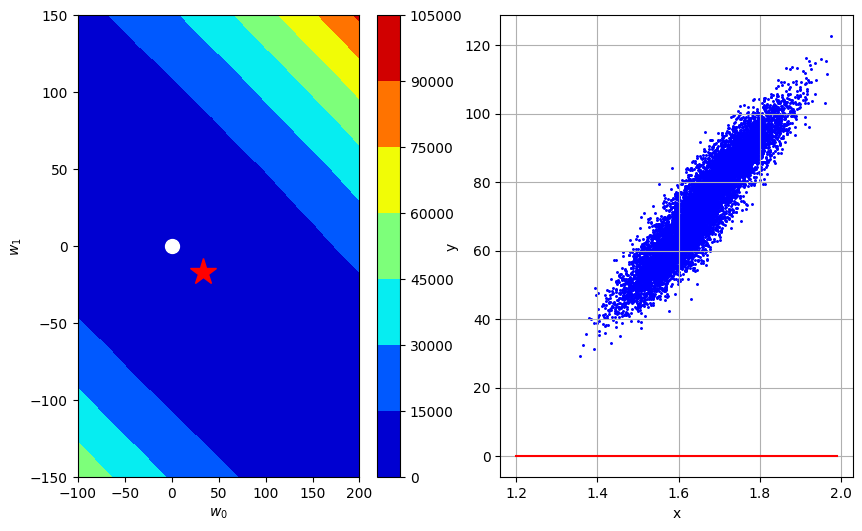

In [84]:
# Time Visualization
from ipywidgets import IntSlider, interact


def plot_figure(n_iter):
    fig = gradient_descent_visualization(
        gd_losses,
        gd_ws,
        grid_losses,
        grid_w0,
        grid_w1,
        mean_x,
        std_x,
        height,
        weight,
        n_iter,
    )
    fig.set_size_inches(10.0, 6.0)


interact(plot_figure, n_iter=IntSlider(min=1, max=len(gd_ws)))

# 4. Stochastic gradient descent

In [85]:
def compute_stoch_gradient(y, tx, w):
    """Compute a stochastic gradient at w from a data sample batch of size B, where B < N, and their corresponding labels.

    Args:
        y: numpy array of shape=(B, )
        tx: numpy array of shape=(B,2)
        w: numpy array of shape=(2, ). The vector of model parameters.

    Returns:
        A numpy array of shape (2, ) (same shape as w), containing the stochastic gradient of the loss at w.
    """
    # same as before, gradient computation
    e = y - tx@w
    N = y.shape[0]
    grad_L = -1/N * tx.T @ e
    return grad_L


def stochastic_gradient_descent(y, tx, initial_w, batch_size, max_iters, gamma):
    """The Stochastic Gradient Descent algorithm (SGD).

    Args:
        y: numpy array of shape=(N, )
        tx: numpy array of shape=(N,2)
        initial_w: numpy array of shape=(2, ). The initial guess (or the initialization) for the model parameters
        batch_size: a scalar denoting the number of data points in a mini-batch used for computing the stochastic gradient
        max_iters: a scalar denoting the total number of iterations of SGD
        gamma: a scalar denoting the stepsize

    Returns:
        losses: a list of length max_iters containing the loss value (scalar) for each iteration of SGD
        ws: a list of length max_iters containing the model parameters as numpy arrays of shape (2, ), for each iteration of SGD
    """

    # Define parameters to store w and loss
    ws = [initial_w]
    losses = [compute_loss(y,tx,initial_w)]
    w = initial_w

    for n_iter in range(max_iters):
        # ***************************************************
        # INSERT YOUR CODE HERE
        # TODO: implement stochastic gradient descent.
        # ***************************************************
        for y_batch, tx_batch in batch_iter(y,tx,batch_size, num_batches=1, shuffle=True):
            # compute gradient of loss on this mini-batch
            grad_L = compute_gradient(y_batch, tx_batch,w)

            # update weights and compute loss
            w = w - gamma*grad_L
            loss = compute_loss(y,tx,w) # full loss, not just batch loss

            # save loss and weights for this iteration
            losses.append(loss)
            ws.append(w)

        print(
            "SGD iter. {bi}/{ti}: loss={l}, w0={w0}, w1={w1}".format(
                bi=n_iter, ti=max_iters - 1, l=loss, w0=w[0], w1=w[1]
            )
        )
    return losses, ws

In [86]:
# from stochastic_gradient_descent import *

# Define the parameters of the algorithm.
max_iters = 50
gamma = 0.1
batch_size = 1

# Initialization
w_initial = np.array([0, 0])

# Start SGD.
start_time = datetime.datetime.now()
sgd_losses, sgd_ws = stochastic_gradient_descent(
    y, tx, w_initial, batch_size, max_iters, gamma
)
end_time = datetime.datetime.now()

# Print result
exection_time = (end_time - start_time).total_seconds()
print("SGD: execution time={t:.3f} seconds".format(t=exection_time))

SGD iter. 0/49: loss=1.715, w0=0.1, w1=0.1
SGD iter. 1/49: loss=0.012000000000000021, w0=0.36, w1=0.8800000000000001
SGD iter. 2/49: loss=0.008063999999999998, w0=0.33599999999999997, w1=0.8560000000000001
SGD iter. 3/49: loss=0.008924159999999974, w0=0.31679999999999997, w1=0.8368000000000001
SGD iter. 4/49: loss=0.008681932799999997, w0=0.31775999999999993, w1=0.83872
SGD iter. 5/49: loss=0.010352033279999999, w0=0.33436799999999994, w1=0.888544
SGD iter. 6/49: loss=0.006956566364159999, w0=0.31207679999999993, w1=0.8662528
SGD iter. 7/49: loss=0.009540433870847978, w0=0.32099327999999994, w1=0.89300224
SGD iter. 8/49: loss=0.009540433870847978, w0=0.32099327999999994, w1=0.89300224
SGD iter. 9/49: loss=0.006411171561209846, w0=0.29959372799999995, w1=0.871602688
SGD iter. 10/49: loss=0.007095029861072235, w0=0.28247408639999994, w1=0.8544830464
SGD iter. 11/49: loss=0.009681968115408793, w0=0.26877837311999997, w1=0.84078733312
SGD iter. 12/49: loss=0.01305702375212391, w0=0.2578218

interactive(children=(IntSlider(value=1, description='n_iter', max=51, min=1), Output()), _dom_classes=('widge…

<function __main__.plot_figure(n_iter)>

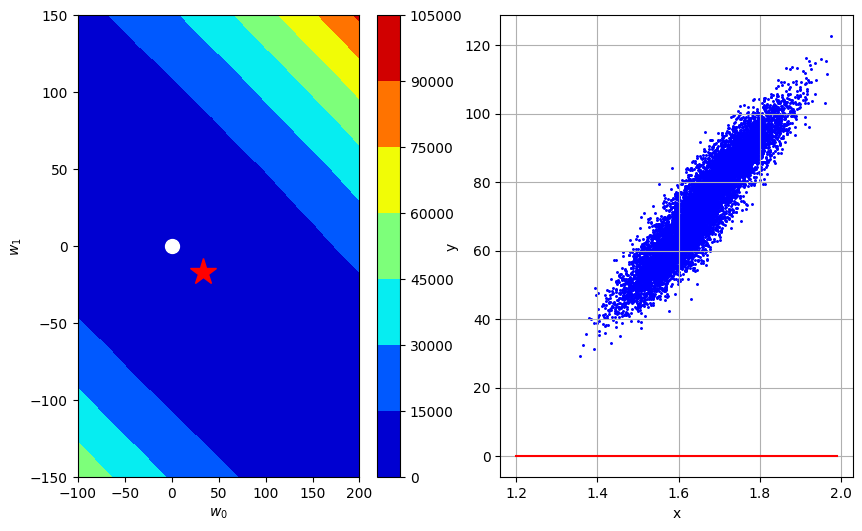

In [87]:
# Time Visualization
from ipywidgets import IntSlider, interact


def plot_figure(n_iter):
    fig = gradient_descent_visualization(
        sgd_losses,
        sgd_ws,
        grid_losses,
        grid_w0,
        grid_w1,
        mean_x,
        std_x,
        height,
        weight,
        n_iter,
    )
    fig.set_size_inches(10.0, 6.0)


interact(plot_figure, n_iter=IntSlider(min=1, max=len(sgd_ws)))

# 5. Effect of Outliers and MAE Cost Function

In [ ]:
import datetime
from helpers import *

# ***************************************************
# INSERT YOUR CODE HERE
# TODO: reload the data by subsampling first, then by subsampling and adding outliers
# ***************************************************
raise NotImplementedError

x, mean_x, std_x = standardize(height)
y, tx = build_model_data(x, weight)

In [ ]:
y.shape, tx.shape

In [ ]:
from plots import gradient_descent_visualization

# Define the parameters of the algorithm.
max_iters = 50
gamma = 0.7

# Initialization
w_initial = np.array([0, 0])

# Start gradient descent.
start_time = datetime.datetime.now()

# ***************************************************
# INSERT YOUR CODE HERE
# TODO: fit the model to the subsampled data / subsampled data with outliers and visualize the cloud of points
#       and the model fit
# ***************************************************
raise NotImplementedError


end_time = datetime.datetime.now()

# Print result
exection_time = (end_time - start_time).total_seconds()
print("GD: execution time={t:.3f} seconds".format(t=exection_time))

In [ ]:
# Time Visualization
from ipywidgets import IntSlider, interact


def plot_figure(n_iter):
    fig = gradient_descent_visualization(
        gd_losses,
        gd_ws,
        grid_losses,
        grid_w0,
        grid_w1,
        mean_x,
        std_x,
        height,
        weight,
        n_iter,
    )
    fig.set_size_inches(10.0, 6.0)


interact(plot_figure, n_iter=IntSlider(min=1, max=len(gd_ws)))

# 6. Subgradient descent

In [ ]:
def compute_subgradient_mae(y, tx, w):
    """Compute a subgradient of the MAE at w.

    Args:
        y: numpy array of shape=(N, )
        tx: numpy array of shape=(N,2)
        w: numpy array of shape=(2, ). The vector of model parameters.

    Returns:
        A numpy array of shape (2, ) (same shape as w), containing the subgradient of the MAE at w.
    """
    # ***************************************************
    # INSERT YOUR CODE HERE
    # TODO: compute subgradient gradient vector for MAE
    # ***************************************************
    raise NotImplementedError

In [ ]:
def subgradient_descent(y, tx, initial_w, max_iters, gamma):
    """The SubGradient Descent (SubGD) algorithm.

    Args:
        y: numpy array of shape=(N, )
        tx: numpy array of shape=(N,2)
        initial_w: numpy array of shape=(2, ). The initial guess (or the initialization) for the model parameters
        max_iters: a scalar denoting the total number of iterations of GD
        gamma: a scalar denoting the stepsize

    Returns:
        losses: a list of length max_iters containing the loss value (scalar) for each iteration of SubGD
        ws: a list of length max_iters containing the model parameters as numpy arrays of shape (2, ), for each iteration of SubGD
    """
    # Define parameters to store w and loss
    ws = [initial_w]
    losses = []
    w = initial_w
    for n_iter in range(max_iters):
        # ***************************************************
        # INSERT YOUR CODE HERE
        # TODO: compute subgradient and loss
        # ***************************************************
        raise NotImplementedError
        # ***************************************************
        # INSERT YOUR CODE HERE
        # TODO: update w by subgradient
        # ***************************************************
        raise NotImplementedError

        ws.append(w)
        losses.append(loss)
        print(
            "SubGD iter. {bi}/{ti}: loss={l}, w0={w0}, w1={w1}".format(
                bi=n_iter, ti=max_iters - 1, l=loss, w0=w[0], w1=w[1]
            )
        )

    return losses, ws

In [ ]:
# Define the parameters of the algorithm.
max_iters = 500
gamma = 0.7
batch_size = 1

# Initialization
w_initial = np.array([0, 0])

# Start SubSGD.
start_time = datetime.datetime.now()
subgd_losses, subgd_ws = subgradient_descent(y, tx, w_initial, max_iters, gamma)
end_time = datetime.datetime.now()

# Print result
exection_time = (end_time - start_time).total_seconds()
print("SubGD: execution time={t:.3f} seconds".format(t=exection_time))

In [ ]:
from ipywidgets import IntSlider, interact


def plot_figure(n_iter):
    fig = gradient_descent_visualization(
        subgd_losses,
        subgd_ws,
        grid_losses,
        grid_w0,
        grid_w1,
        mean_x,
        std_x,
        height,
        weight,
        n_iter,
    )
    fig.set_size_inches(10.0, 6.0)


interact(plot_figure, n_iter=IntSlider(min=1, max=len(subgd_ws)))

# Stochastic Subgradient Descent

**NB** for the computation of the subgradient you can reuse the `compute_subgradient` method that you implemented above, just making sure that you pass in a minibatch as opposed to the full data.

In [ ]:
def stochastic_subgradient_descent(y, tx, initial_w, batch_size, max_iters, gamma):
    """Compute a stochastic subgradient at w from a data sample batch of size B, where B < N, and their corresponding labels.

    Args:
        y: numpy array of shape=(B, )
        tx: numpy array of shape=(B,2)
        initial_w: numpy array of shape=(2, ). The initial guess (or the initialization) for the model parameters
        batch_size: a scalar denoting the number of data points in a mini-batch used for computing the stochastic subgradient
        max_iters: a scalar denoting the total number of iterations of SubSGD
        gamma: a scalar denoting the stepsize

    Returns:
        losses: a list of length max_iters containing the loss value (scalar) for each iteration of SubSGD
        ws: a list of length max_iters containing the model parameters as numpy arrays of shape (2, ), for each iteration of SubSGD
    """

    # Define parameters to store w and loss
    ws = [initial_w]
    losses = []
    w = initial_w

    for n_iter in range(max_iters):
        # ***************************************************
        # INSERT YOUR CODE HERE
        # TODO: implement stochastic subgradient descent.
        # ***************************************************
        raise NotImplementedError

        print(
            "SubSGD iter. {bi}/{ti}: loss={l}, w0={w0}, w1={w1}".format(
                bi=n_iter, ti=max_iters - 1, l=loss, w0=w[0], w1=w[1]
            )
        )
    return losses, ws

In [ ]:
# Define the parameters of the algorithm.
max_iters = 500
gamma = 0.7
batch_size = 1

# Initialization
w_initial = np.array([0, 0])

# Start SubSGD.
start_time = datetime.datetime.now()
subsgd_losses, subsgd_ws = stochastic_subgradient_descent(
    y, tx, w_initial, batch_size, max_iters, gamma
)
end_time = datetime.datetime.now()

# Print result
exection_time = (end_time - start_time).total_seconds()
print("SubSGD: execution time={t:.3f} seconds".format(t=exection_time))

In [ ]:
from ipywidgets import IntSlider, interact


def plot_figure(n_iter):
    fig = gradient_descent_visualization(
        subsgd_losses,
        subsgd_ws,
        grid_losses,
        grid_w0,
        grid_w1,
        mean_x,
        std_x,
        height,
        weight,
        n_iter,
    )
    fig.set_size_inches(10.0, 6.0)


interact(plot_figure, n_iter=IntSlider(min=1, max=len(subsgd_ws)))